<br>
<br>
<br>

---

# Imports and Environment Vars

In [1]:
import os

import json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import fbeta_score, precision_score, recall_score,classification_report,confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import itertools

import spacy
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import f1_score

## Environment Vars

In [2]:
BATCH_SIZE = 16
MAX_SEQ_LEN = 512
WORD_INDEX_FOR_PADDING = -100
PII = ["B-NAME_STUDENT", "B-USERNAME", "I-NAME_STUDENT","O"]

In [3]:
os.environ["TF_USE_LEGACY_KERAS"] = "1"

## Libraries

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)
plt.style.use("ggplot")

In [ ]:
# print('Tensorflow version:', tf.__version__)
# print('GPU detected:', tf.config.list_physical_devices('GPU'))

In [5]:
from tensorflow.keras.mixed_precision import set_global_policy

# Set the global policy to mixed_float16
set_global_policy('mixed_float16')

# keras.mixed_precision.set_global_policy("mixed_float16")

<br>
<br>
<br>

---


# Data Loading & Preprocessing

In [6]:
#BASE_PATH = "/content/drive/MyDrive/266/266 Final Project Team/kaggle_data"
BASE_PATH = "/content/drive/MyDrive/MIDS_W266_DATA/"

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
data = pd.read_json(f"{BASE_PATH}/train.json")

In [10]:
def clean_df(data):
  doc_index = []
  tokens = []
  labels = []
  docs = []
  token_index = []
  for index, row in data.iterrows():
    document = row['full_text']
    for i, (tok, lab) in enumerate(zip(row['tokens'], row['labels'])):
      doc_index.append(index)
      tokens.append(tok)
      labels.append(lab)
      token_index.append(i)
      docs.append(document)

  return pd.DataFrame({"doc": docs, "doc_index": doc_index, "word": tokens, "label": labels, "word_index": token_index})

df = clean_df(data)
full_texts = df.doc.unique()

In [12]:
words = list(set(df["word"].values))
words2idx = {w: i for i, w in enumerate(words)}
words.append("ENDPAD")
num_words = len(words)

tags = PII
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for i, t in enumerate(tags)}
num_tags = len(PII)

In [13]:
# get_doc_word_label_pairs creates a list for each document where each item is a list of tuples (word, label)
# also ensures that each label in the tuples are contained within the valid list of PII to identify, otherwise marked with label 'O'
def get_doc_word_label_pairs(data):
  agg_func = lambda d: [(w,l) if l in tags else (w, 'O') for w, l in zip(d["word"].values.tolist(),
                                                           d["label"].values.tolist())]
  return df.groupby('doc_index').apply(agg_func).tolist()

doc_word_label_pairs=get_doc_word_label_pairs(df)

In [14]:
def get_doc_word_label_arrays(data):
  agg_func_word = lambda d: [str(w) for w in d["word"].values.tolist()]
  agg_func_token = lambda d: [str(t) if t in tags else "O" for t in d["label"].values.tolist()]
  return data.groupby('doc_index').apply(agg_func_word).tolist(), data.groupby('doc_index').apply(agg_func_token).tolist()

doc_word_label_arrays=get_doc_word_label_arrays(df)

In [15]:
word2idx = {w: i + 1 for i, w in enumerate(words)}

X = [[word2idx[w[0]] for w in d] for d in doc_word_label_pairs]
X = pad_sequences(maxlen=MAX_SEQ_LEN, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in d] for d in doc_word_label_pairs]
y = pad_sequences(maxlen=MAX_SEQ_LEN, sequences=y, padding="post", value=tag2idx["O"])

<br>
<br>
<br>

---


# Evaluation


In [16]:
def generate_class_report(true_labels, predicted_labels,
                          LABELS=[0,1,2,3],
                          TARGET_NAMES=PII):
  # true_labels' & 'predicted_labels: arrays of shape (n_samples,) or (n_samples, n_outputs)
  if isinstance(true_labels, np.ndarray):
    true_labels = true_labels.flatten()
  if isinstance(predicted_labels, np.ndarray):
    predicted_labels = predicted_labels.flatten()
  report = classification_report(true_labels, predicted_labels,
                                 labels=LABELS,
                                 target_names=TARGET_NAMES,
                                 zero_division=0.0) # default='warn'
  print(report)

In [17]:
def multi_class_fbeta(ytrue , ypred, beta=5.0, average='micro', epsilon=1e-7):
    # epsilon is set to avoid division by zero error
    beta_squared = beta**2
    ytrue = tf.one_hot(tf.cast(ytrue, tf.int32), num_tags)

    # casting ytrue and ypred as floats
    ytrue = tf.cast(ytrue, tf.float32)
    ypred= tf.cast(ypred, tf.float32)

    # finding the maximum probability in ypred
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

    # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)

    tp = tf.reduce_sum(ytrue*ypred, axis=0) # calculating true positives
    predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
    actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives

    # calculating precision and recall
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    # finding fbeta
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    if average == 'weighted':
      supports = tf.reduce_sum(ytrue, axis=0)
      return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

    elif average == 'raw': # raw returns the fbeta scores without aggregating them
      return fb

    return tf.reduce_mean(fb)

<br>
<br>
<br>

---

# Spacy Baseline Model

In [18]:
nlp = spacy.load("en_core_web_sm")

In [19]:
def validate_spacy_for_data(full_texts, word_label_pairs):
  for full_text, token_label_pairs in zip(full_texts, word_label_pairs):
    spacy_doc = nlp(full_text)
    if len(spacy_doc) != len(token_label_pairs):
      print("Error: mismatch between spacy tokens and data")

validate_spacy_for_data(full_texts, doc_word_label_pairs)

In [20]:
def predict_with_spacy(full_texts, word_label_pairs, full_results=False):
  true_positives = []
  false_positives = []
  true_negatives = []
  false_negatives = []
  y_pred = []
  y_true = []
  for doc_i, (full_text, token_label_pairs) in enumerate(zip(full_texts, word_label_pairs)):
    spacy_doc = nlp(full_text)
    for i in range(len(spacy_doc)):
      y_true.append(token_label_pairs[i][1])
      if spacy_doc[i].ent_type_ == "PERSON":
        if spacy_doc[i].ent_iob_ == "B":
          # predicted_label "B-NAME_STUDENT"
          y_pred.append("B-NAME_STUDENT")
          if (token_label_pairs[i][1] == "B-NAME_STUDENT"):
            true_positives.append((doc_i, i, token_label_pairs[i][0], token_label_pairs[i][1], "B-NAME_STUDENT"))
          else:
            false_positives.append((doc_i, i, token_label_pairs[i][0], token_label_pairs[i][1], "B-NAME_STUDENT"))
        else: # predicted_label "I-NAME_STUDENT"
          y_pred.append("I-NAME_STUDENT")
          if (token_label_pairs[i][1] == "I-NAME_STUDENT"):
            true_positives.append((doc_i, i, token_label_pairs[i][0], token_label_pairs[i][1], "I-NAME_STUDENT"))
          else:
            false_positives.append((doc_i, i, token_label_pairs[i][0], token_label_pairs[i][1], "I-NAME_STUDENT"))
      else: # predicted_label "O"
        y_pred.append("O")
        if (token_label_pairs[i][1] != "O"):
          false_negatives.append((doc_i, i, token_label_pairs[i][0], token_label_pairs[i][1], "O"))
        else:
          true_negatives.append((doc_i, i, token_label_pairs[i][0], token_label_pairs[i][1], "O"))
  if full_results: return true_positives, false_positives, true_negatives, false_negatives
  else: return [tag2idx[t] for t in y_true], [tag2idx[t] for t in y_pred]

y_true, y_pred = predict_with_spacy(full_texts, doc_word_label_pairs)

In [21]:
# tag2idx = {t: i for i, t in enumerate(tags)}
# weights2tag = {i: w for i, w in enumerate(weights)}
# spacy_f1 = f1_score(y_true, y_pred, average='samples', sample_weight=weights)

spacy_weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Spacy model weighted f1 score: {spacy_weighted_f1}")

Spacy model weighted f1 score: 0.997827158072648


In [22]:
true_positives, false_positives, true_negatives, false_negatives = predict_with_spacy(full_texts, doc_word_label_pairs, full_results=True)

(document index, token index , token, true label, predicted label)

In [23]:
# generate spacy classificaton report
generate_class_report(y_pred, y_true)

                precision    recall  f1-score   support

B-NAME_STUDENT       0.67      0.08      0.15     10798
    B-USERNAME       0.00      0.00      0.00         0
I-NAME_STUDENT       0.70      0.10      0.18      7656
             O       1.00      1.00      1.00   4974079

      accuracy                           1.00   4992533
     macro avg       0.59      0.30      0.33   4992533
  weighted avg       1.00      1.00      1.00   4992533



Normalized confusion matrix
[[0.66739927 0.         0.003663   0.32893773]
 [0.         0.         0.         1.        ]
 [0.01277372 0.         0.69981752 0.28740876]
 [0.00197853 0.         0.00137954 0.99664193]]


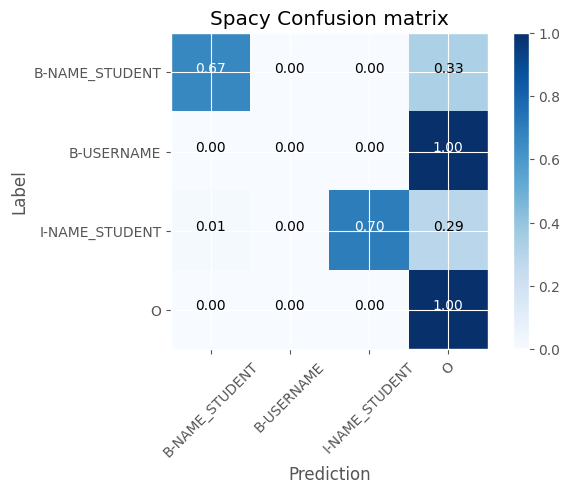

<Figure size 640x480 with 0 Axes>

In [24]:
# alt. function version
def plot_confusion_matrix_v2(y_true, y_pred,
                             classes=PII,
                             normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Label')
    plt.xlabel('Prediction')
    plt.figure()
    plt.show()

class_names = ['B-NAME_STUDENT', 'B-USERNAME', 'I-NAME_STUDENT', 'O']


# def plot_confusion_matrix(y_true, y_pred,
#                           classes=PII,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     cm = confusion_matrix(y_true, y_pred)
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('Label')
#     plt.xlabel('Prediction')
#     plt.figure()
#     plt.show()

# # class_names = ['B-NAME_STUDENT', 'B-USERNAME', 'I-NAME_STUDENT', 'O']
# plt.figure()
plot_confusion_matrix_v2(y_true, y_pred, classes=PII, normalize=True, title='Spacy Confusion matrix')

In [28]:
# should make this adjustible to return doc_id, word_index, etc.
from collections import Counter
# spacy output format: (doc_index, word_index, word, true_label, pred_label) 185, 853, 'Mapping', 'O', 'I-NAME_STUDENT')
# returns sorted list of tuples (word, count) by frequency
def get_top_n_words_by_class(model_output,
                             actual_tag,
                             pred_tag=None, # optional: filter by specific prediction
                             n=10):
  if pred_tag:
      filtered_words = [word for _, _, word, tag, pred_tag in model_output if tag == actual_tag]
  else:
    filtered_words = [word for _, _, word, tag, _ in model_output if tag == actual_tag]
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(n)
    return top_words

In [29]:
get_top_n_words_by_class(false_negatives,'B-NAME_STUDENT')

[('Emily', 18),
 ('Fabrizio', 16),
 ('Vincenzo', 6),
 ('Luca', 5),
 ('Diego', 4),
 ('Mohd', 4),
 ('Rhiannon', 4),
 ('Irina', 4),
 ('Nandan', 4),
 ('Youssef', 4)]

In [30]:
get_top_n_words_by_class(false_positives,'B-NAME_STUDENT')

[('Alison', 1), ('Shujon', 1), ('El', 1), ('Omar', 1), ('Benjamin', 1)]

In [31]:
get_top_n_words_by_class(false_negatives,'I-NAME_STUDENT')

[('Kumar', 7),
 ('Singh', 6),
 ('Garcia', 5),
 ('Rivera', 4),
 ('Karim', 4),
 ('Farrag', 4),
 ('Sylla', 3),
 ('Dias', 3),
 ('Uddin', 3),
 ('Khan', 3)]

In [32]:
get_top_n_words_by_class(false_positives,'I-NAME_STUDENT')

[('Kumar', 2),
 ('Ari', 2),
 ('Patel', 1),
 ('Khan', 1),
 ('Garcia', 1),
 ('Ruslan', 1),
 ('Hassan', 1),
 ('Ansari', 1),
 ('Thomas', 1),
 ('Seifert', 1)]

In [33]:
get_top_n_words_by_class(false_negatives,'B-USERNAME')

[('fdixon', 2),
 ('castanedagabriel', 1),
 ('meyermichelle', 1),
 ('jacob59', 1),
 ('holmespatrick', 1)]

In [34]:
get_top_n_words_by_class(false_positives,'B-USERNAME')

[]

## Displacy results visualization

In [ ]:
import displacy

In [ ]:
import spacy
from spacy import displacy

text = "When Sebastian Thrun started working on self-driving cars at Google in 2007, few people outside of the company took him seriously."

nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
displacy.serve(doc, style="ent")

In [ ]:
# @title
# !mkdir /model_output

# true_positives.to_csv(f"{BASE_PATH}/spacy_true_positives.csv", index=False)
# false_positives.to_csv(f"{BASE_PATH}/spacy_false_positives.csv", index=False)
# true_negatives.to_csv(f"{BASE_PATH}/spacy_true_negatives.csv", index=False)
# false_negatives.to_csv(f"{BASE_PATH}/spacy_false_negatives.csv", index=False)

<br>
<br>
<br>

---

# Data augmentation for spacy experimentation (not yet implemented)

In [ ]:
# import random

# def lowercase_augmentation(tokens, labels, lowercase_prob=0.2):
#     # assumes tokens & labels are lists of same length
#     # returns augmented_tokens & original labels
#     augmented_tokens = [token.lower() if random.random() < lowercase_prob else token for token in tokens]
#     return augmented_tokens, labels
# --> map to full texts full_texts
# augmented_tokens, augmented_labels = lowercase_augmentation(test_token_list, test_label_list)

# print("Original:", list(zip(test_token_list, test_token_list)))
# print("Augmented:", list(zip(augmented_tokens, augmented_labels)))